In [50]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from jax import nn, random, lax, vmap, ops
from scipy.special import binom

from time import time_ns

from opt_einsum import contract, contract_expression

import sys
import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

def einsum(equation, *args, optimize=True):
    return contract(equation, *args, backend='jax', optimize=optimize)

sns.set(context='talk', style='white', color_codes=True, font_scale=.75)

In [4]:
from scipy import io
# load experiment and define generator for observations
data = io.loadmat('main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 1

outcomes1 = jnp.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = jnp.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

Define negative binomial distribution in a discrete phase-type representation

In [5]:
vdiag = vmap(lambda v: jnp.diag(v, k=0))
voffd = vmap(lambda v: jnp.diag(v, k=1))

# max possible precision
n = 10
nu = jnp.arange(1, n + 1)

# discretisation of mean values
mu = jnp.arange(4., 45., 1)
p = mu[..., None]/(nu[None] + mu[..., None])

# return probabilities
j = jnp.tril(jnp.arange(1, n + 1)[None].repeat(n, 0))
bnm = binom(nu[..., None], jnp.tril(j-1))
p1 = p[..., None] ** jnp.tril((nu[..., None] - j + 1))
p2 = (1 - p[..., None])**jnp.tril(j - 1)
pi =  jnp.tril(bnm * p1 * p2)
pi = jnp.concatenate([pi, 1 - pi.sum(-1, keepdims=True)], -1)

# phase transition matrix for different models m, f_t| f_{t+1}
p_ff = []
for i in range(n):
    vp = p[..., i:i + 1].repeat(i + 1, -1)
    tmp = jnp.concatenate([vdiag(vp) + voffd(1 - vp[..., :-1]), jnp.zeros((p.shape[0], i + 1, n - i - 1))], -1)
    tmp = jnp.concatenate([tmp, 1 - tmp.sum(-1, keepdims=True)], -1)
    tmp = jnp.concatenate([tmp, jnp.ones((p.shape[0], n - i - 1, n + 1))/(n + 1)], -2)
    tmp = jnp.concatenate([tmp, pi[:, i:i+1]], -2)
    p_ff.append(tmp)

p_mff = jnp.stack(p_ff, -3).reshape(-1, n + 1, n + 1)

def nb_dist(mu, nu, d_max):
    d = jnp.expand_dims(jnp.arange(1., d_max + 1.), -1)[..., None]
    k = d - 1.
    p = mu / (nu + mu)
    
    return binom(k + nu - 1, k) * (1 - p)**nu * p ** k

d_max = 50
dist = nb_dist(mu[:, None], nu[None], d_max)

# state transition matrix f_t, j_t| j_{t+1}
p_fjj = jnp.zeros((n+1, 2, 2))
p_fjj = ops.index_add(p_fjj, ops.index[-1, :, 1], 1.)
p_fjj = ops.index_add(p_fjj, ops.index[:-1, :, 0], 1.)

# state transition matrix j_t, c_t | c_{t+1}
p_jcc = jnp.stack([jnp.eye(2), (jnp.ones((2, 2)) - jnp.eye(2))], 0)
p_fcc = einsum('jcz,fj->fcz', p_jcc, p_fjj[:, 0])

In [51]:
from jax.scipy.special import digamma
vdiag = vmap(lambda v: jnp.diag(v, k=0))
voffd = vmap(lambda v: jnp.diag(v, k=1))
def log(x, minimum=-1e10):
    return jnp.where(x > 0, jnp.log(x), minimum) 

class Agent(object):
    def __init__(self, N, nu_max=1, nu_min=0):
        self.N = N
        self.nu_max = nu_max
        self.nu_min = nu_min
        
        self.__make_transition_matrices()
        self.__set_prior()
        
    def __make_transition_matrices(self):
        nu = jnp.arange(1, self.nu_max + 1)
        mu = jnp.arange(4., 45., 1.)
        p = mu[..., None]/(nu[None] + mu[..., None])
        
        j = jnp.tril(jnp.arange(1, self.nu_max + 1)[None].repeat(self.nu_max, 0))
        bnm = binom(nu[..., None], jnp.tril(j-1))
        p1 = p[..., None] ** jnp.tril((nu[..., None] - j + 1))
        p2 = (1 - p[..., None])**jnp.tril(j - 1)
        pi =  jnp.tril(bnm * p1 * p2)
        pi = jnp.concatenate([pi, 1 - pi.sum(-1, keepdims=True)], -1)
        
        # phase transition matrix for different models m, f_t| f_{t+1}
        p_ff = []
        for i in range(self.nu_max):
            vp = p[..., i:i + 1].repeat(i + 1, -1)
            tmp = jnp.concatenate([vdiag(vp) + voffd(1 - vp[..., :-1]), jnp.zeros((p.shape[0], i + 1, self.nu_max - i - 1))], -1)
            tmp = jnp.concatenate([tmp, 1 - tmp.sum(-1, keepdims=True)], -1)
            tmp = jnp.concatenate([tmp, jnp.ones((p.shape[0], self.nu_max - i - 1, self.nu_max + 1))/(self.nu_max + 1)], -2)
            tmp = jnp.concatenate([tmp, pi[:, i:i+1]], -2)
            p_ff.append(tmp)
        
        self.p_mff = jnp.stack(p_ff, -3).reshape(-1, self.nu_max + 1, self.nu_max + 1)
        
        # state transition matrix f_t, j_t| j_{t+1}
        p_fjj = jnp.zeros((self.nu_max + 1, 2, 2))
        p_fjj = ops.index_add(p_fjj, ops.index[-1, :, 1], 1.)
        p_fjj = ops.index_add(p_fjj, ops.index[:-1, :, 0], 1.)
        
        p_jcc = jnp.stack([jnp.eye(2), (jnp.ones((2, 2)) - jnp.eye(2))], 0)

        self.p_fcc = einsum('jcz,fj->fcz', p_jcc, p_fjj[:, 0])
        
    def __set_prior(self, a=6., b=32.):
        prior_mf = self.p_mff[:, -1]
        M = prior_mf.shape[0]
        prior_m = jnp.ones(M)/M
        prior_m = prior_m.reshape(self.nu_max, -1)
        prior_m = jnp.concatenate([jnp.zeros_like(prior_m[:self.nu_min]), prior_m[self.nu_min:]], 0).reshape(-1)
        prior_m /= prior_m.sum()
        prior_fm = (prior_mf * prior_m[:, None]).T
        prior_c = jnp.ones(2)/2

        pars = jnp.array([
            [[a, b, 1, 1], [b, a, 1, 1]],
            [[b, a, 1, 1], [a, b, 1, 1]],
            [[1, 1, 1000., 1], [1, 1, 1, 1000.]]
        ])[None].repeat(self.N, 0)
        
        probs = einsum('c,fm->cfm', prior_c, prior_fm)[None].repeat(self.N, 0)
        self.prior = (probs, pars)
        
    
    def __par_efe(self, p_c, params, U):
        p_aco = params/params.sum(-1, keepdims=True)
        q_ao = einsum('...aco,...c->...ao', p_aco, p_c)
    
        KL_a =  - jnp.sum(q_ao * U, -1) + jnp.sum(q_ao * log(q_ao), -1)
    
        H_ac = - (p_aco * digamma(params)).sum(-1) + digamma(params.sum(-1) + 1)
        H_a = einsum('...c,...ac->...a', p_c, H_ac)
    
        return KL_a + H_a
    
    def logits(self, beliefs, gamma, U):
        p_cfm, params = beliefs

        # expected surprisal based action selection
        p_c = einsum('...cfm->...c', p_cfm, optimize=False)

        S_a = self.__par_efe(p_c, params, U)

        return - gamma * ( S_a - S_a.min(-1, keepdims=True))

    def action_selection(self, rng_key, beliefs, gamma=1e3, U=jnp.array([-1., 1., 0., 0.])):
        # sample choices
        return random.categorical(rng_key, logits(self, beliefs, gamma, U))

    # parametric learning and inference
    def learning(self, observations, responses, mask, prior):
        p_cfm, params = prior
        obs = jnp.eye(4)[observations]

        p_aco = params/params.sum(-1, keepdims=True)

        p_c = einsum('nco,no->nc', p_aco[jnp.arange(self.N), responses], obs)
        
        m = jnp.expand_dims(mask, -1)
        p_c = m * p_c + (1 - m)/2.

        post = einsum('nc,ncfm->ncfm', p_c, p_cfm)
        
        norm = post.reshape(post.shape[:-3] + (-1,)).sum(-1)[..., None, None, None]
        post = post/norm

        resp = jnp.eye(3)[responses]
        post_c = post.reshape(post.shape[:-2] + (-1,)).sum(-1)

        params_new = params + einsum('na,nc,no,n->naco', resp, post_c, obs, mask)
        pred = einsum('fcz,mfg,ncfm->nzgm', self.p_fcc, self.p_mff, post)

        return (pred, params_new)
    
# implement simulator for POMDP
def estimate_beliefs(outcomes, choices, masks, nu_max=1):
    T, N = choices.shape
    assert outcomes.shape == (T, N)
    assert masks.shape == (T, N)
    agent = Agent(N, nu_max=nu_max)
    def sim_fn(carry, t):
        prior = carry
        posterior = agent.learning(outcomes[t], choices[t], masks[t], prior)
                
        return posterior, {'beliefs': prior}
    
    _, sequence = lax.scan(sim_fn, agent.prior, jnp.arange(T))
    
    sequence['beliefs'][0].block_until_ready()
    
    return sequence, agent

In [53]:
import numpyro as npyro
import numpyro.distributions as dist
from numpyro.handlers import mask as npyro_mask
from jax.scipy.special import logsumexp

def model(beliefs, agent, y=None, mask=True):
    T, N = beliefs[0].shape[:2]
    with npyro.plate('N', N):
        gamma = npyro.sample('gamma', dist.Gamma(20., 2.))
        lams = npyro.sample('lams', dist.Normal(jnp.array([-1., 1.]), 2*jnp.ones(2)).to_event(1))
        with npyro.plate('T', T):
            U = jnp.stack([lams[..., 0], lams[..., 1], jnp.zeros_like(lams[..., 1]), jnp.zeros_like(lams[..., 1])], -1)
            U -= logsumexp(U)
            logits = agent.logits(beliefs, jnp.expand_dims(gamma, -1), jnp.expand_dims(U, -2))
            obs = npyro.sample('obs', dist.CategoricalLogits(logits).mask(mask), obs=y)

In [40]:
from numpyro.infer import MCMC, NUTS
from numpyro.infer import log_likelihood
from jax.scipy.special import logsumexp

def log_pred_density(model, samples, *args, **kwargs):
    log_lk = log_likelihood(model, samples, *args, **kwargs)['obs'].sum(-2)
    n = log_lk.shape[0]
    _lpd = logsumexp(log_lk, 0) - jnp.log(n)
    p_waic = n * log_lk.var(0)/(n - 1)
    return {'lpd': _lpd, 'waic': _lpd - p_waic}

In [41]:
from stats import load_data

outcomes_data, responses_data, mask_data, ns = load_data()

mask_data = jnp.array(mask_data)
responses_data = jnp.array(responses_data).astype(jnp.int32)
outcomes_data = jnp.array(outcomes_data).astype(jnp.int32)

In [42]:
sequences = {}
agents = {}
for nu_max in range(1, 11):
    sequences[nu_max], agents[nu_max] = estimate_beliefs(outcomes_data, responses_data, mask_data, nu_max=nu_max)

In [54]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1500, num_samples=1000)

rng_key = random.PRNGKey(23478)
cutoff = 800
samples = {}
for nu_max in sequences:
    rng_key, _rng_key = random.split(rng_key)
    seq = (sequences[nu_max]['beliefs'][0][-cutoff:], 
           sequences[nu_max]['beliefs'][1][-cutoff:])
    mcmc.run(
        _rng_key, 
        seq, 
        agents[nu_max], 
        y=responses_data[-cutoff:], 
        mask=mask_data[-cutoff:].astype(bool), 
        extra_fields=('potential_energy',)
    )
    
    pe = mcmc.get_extra_fields()['potential_energy']
    print('Expected log joint density: {:.2f}'.format(jnp.mean(-pe)))
    
    mcmc.print_summary()
    samples[nu_max] = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [1:01:40<00:00,  1.48s/it, 511 steps of size 8.09e-03. acc. prob=0.95] 


Expected log joint density: -24277.12

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.72      2.21     10.62      7.15     14.22   1599.66      1.00
  gamma[1]      9.03      1.99      8.91      5.46     11.84   1452.14      1.00
  gamma[2]      9.69      2.27      9.45      6.38     13.72   1578.19      1.00
  gamma[3]     12.68      2.21     12.66      9.21     16.40   1046.15      1.00
  gamma[4]      8.48      1.73      8.39      5.69     11.16    883.57      1.00
  gamma[5]      9.21      1.93      9.16      6.14     12.23   1459.91      1.00
  gamma[6]      9.93      2.11      9.74      6.65     13.38   1945.40      1.00
  gamma[7]      9.94      2.01      9.78      6.48     12.95   1981.24      1.00
  gamma[8]     10.20      2.22     10.06      6.76     13.75   1237.09      1.00
  gamma[9]     10.17      2.35      9.99      5.99     13.61   1449.67      1.00
 gamma[10]      8.70      1.89      8.66      5.89     11.84   1424.05

sample: 100%|██████████| 2500/2500 [1:01:09<00:00,  1.47s/it, 511 steps of size 1.03e-02. acc. prob=0.92]


Expected log joint density: -24310.44

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.53      2.32     10.38      6.90     14.47   2065.36      1.00
  gamma[1]      8.91      1.88      8.80      5.77     11.83   2082.76      1.00
  gamma[2]      9.75      2.06      9.60      6.20     12.75   1654.13      1.00
  gamma[3]     14.13      2.15     14.06     10.58     17.50   1911.30      1.00
  gamma[4]      8.79      1.94      8.62      5.80     11.97   1813.72      1.00
  gamma[5]      9.49      2.09      9.30      6.19     12.95   1714.38      1.00
  gamma[6]     10.23      2.13     10.07      6.91     13.58   1388.07      1.00
  gamma[7]     10.32      2.08     10.20      6.90     13.60   1400.61      1.00
  gamma[8]     10.32      2.27     10.07      6.68     13.90   1520.68      1.00
  gamma[9]     10.28      2.22     10.12      6.53     13.37   1732.30      1.00
 gamma[10]      8.68      1.93      8.53      5.40     11.65   1931.62

sample: 100%|██████████| 2500/2500 [59:16<00:00,  1.42s/it, 511 steps of size 8.57e-03. acc. prob=0.94]  


Expected log joint density: -24567.67

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.36      2.46     10.27      6.80     14.44   2127.28      1.00
  gamma[1]      8.68      1.83      8.61      5.49     11.21   2130.95      1.00
  gamma[2]      9.92      2.02      9.81      6.49     13.05   1602.60      1.00
  gamma[3]     14.69      2.22     14.53     11.53     18.54   2301.31      1.00
  gamma[4]      8.92      1.93      8.72      6.12     12.11   1804.24      1.00
  gamma[5]      9.52      2.12      9.36      6.27     13.24   2120.85      1.00
  gamma[6]     10.47      2.20     10.38      7.04     13.91   1802.27      1.00
  gamma[7]     10.55      2.18     10.49      7.02     13.84   1809.12      1.00
  gamma[8]     10.25      2.32     10.09      6.57     13.98   1483.64      1.00
  gamma[9]     10.29      2.29     10.09      6.85     14.15   1778.80      1.00
 gamma[10]      8.56      1.83      8.47      5.57     11.16   1578.62

sample: 100%|██████████| 2500/2500 [57:29<00:00,  1.38s/it, 511 steps of size 8.42e-03. acc. prob=0.94]  


Expected log joint density: -24853.27

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.11      2.14     10.00      6.77     13.66   1224.28      1.00
  gamma[1]      8.56      1.79      8.39      5.76     11.58   1276.65      1.00
  gamma[2]      9.90      2.10      9.77      6.40     13.01   1022.90      1.00
  gamma[3]     14.96      1.88     14.93     11.86     17.85   1656.66      1.00
  gamma[4]      8.97      1.89      8.73      6.04     12.00   1459.90      1.00
  gamma[5]      9.56      2.17      9.43      6.09     13.09   1401.70      1.00
  gamma[6]     10.54      2.12     10.47      7.03     13.82   1589.54      1.00
  gamma[7]     10.74      2.27     10.64      7.15     14.39   1360.63      1.00
  gamma[8]     10.33      2.28     10.14      6.60     13.83   1141.40      1.00
  gamma[9]     10.41      2.21     10.27      6.81     13.88   1292.15      1.00
 gamma[10]      8.64      2.00      8.49      5.31     11.76   1153.80

sample: 100%|██████████| 2500/2500 [59:13<00:00,  1.42s/it, 511 steps of size 8.69e-03. acc. prob=0.93]  


Expected log joint density: -25117.53

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.11      2.30      9.93      6.60     14.08   2568.99      1.00
  gamma[1]      8.40      1.86      8.29      5.48     11.41   1647.06      1.00
  gamma[2]      9.96      2.25      9.76      6.69     13.80   1554.44      1.00
  gamma[3]     15.22      2.16     15.16     11.94     19.09   1697.25      1.00
  gamma[4]      9.01      1.84      8.87      5.98     11.73   1288.02      1.00
  gamma[5]      9.55      2.06      9.51      6.03     12.59   1840.04      1.00
  gamma[6]     10.83      2.24     10.74      7.52     14.75   1557.70      1.00
  gamma[7]     10.95      2.44     10.75      6.95     14.75   1939.37      1.00
  gamma[8]     10.36      2.26     10.22      6.64     13.88   1660.74      1.00
  gamma[9]     10.25      2.30     10.04      6.79     14.13   1695.31      1.00
 gamma[10]      8.39      1.95      8.26      5.12     11.28   1258.02

sample: 100%|██████████| 2500/2500 [56:43<00:00,  1.36s/it, 511 steps of size 9.21e-03. acc. prob=0.93]  


Expected log joint density: -25352.72

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.08      2.27      9.92      6.63     13.86   1621.71      1.00
  gamma[1]      8.44      1.82      8.29      5.27     11.13   2367.83      1.00
  gamma[2]      9.96      2.16      9.78      6.43     13.27   1320.31      1.00
  gamma[3]     15.43      2.08     15.33     12.20     18.93   1774.36      1.00
  gamma[4]      8.99      1.86      8.89      5.94     11.71   1650.46      1.00
  gamma[5]      9.64      2.16      9.40      5.98     12.93   2011.73      1.00
  gamma[6]     10.95      2.25     10.83      7.52     14.70   1582.84      1.00
  gamma[7]     10.94      2.24     10.79      7.47     14.69   1849.19      1.00
  gamma[8]     10.39      2.29     10.23      6.78     14.11   2168.08      1.00
  gamma[9]     10.30      2.30     10.17      6.67     14.04   1945.32      1.00
 gamma[10]      8.41      1.89      8.26      5.63     11.60   1781.90

sample: 100%|██████████| 2500/2500 [58:20<00:00,  1.40s/it, 511 steps of size 9.23e-03. acc. prob=0.92]  


Expected log joint density: -25560.84

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.93      2.36      9.68      5.98     13.42   1611.29      1.00
  gamma[1]      8.22      1.86      8.12      5.30     11.28   1529.22      1.00
  gamma[2]      9.93      2.01      9.83      6.76     13.19   2037.23      1.00
  gamma[3]     15.37      2.04     15.28     12.03     18.66   2016.93      1.00
  gamma[4]      8.97      1.98      8.83      5.48     11.81   1676.83      1.00
  gamma[5]      9.57      1.97      9.37      6.23     12.55   1321.95      1.00
  gamma[6]     11.06      2.17     10.88      7.60     14.49   2549.49      1.00
  gamma[7]     10.97      2.37     10.82      7.11     14.97   1516.93      1.00
  gamma[8]     10.32      2.19     10.21      6.46     13.46   1740.10      1.00
  gamma[9]     10.34      2.19     10.13      7.19     14.34   1284.61      1.00
 gamma[10]      8.38      1.85      8.26      5.73     11.58   1457.87

sample: 100%|██████████| 2500/2500 [1:01:14<00:00,  1.47s/it, 511 steps of size 9.96e-03. acc. prob=0.91]


Expected log joint density: -25745.14

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.97      2.27      9.74      6.42     13.43   2138.94      1.00
  gamma[1]      8.08      1.64      7.98      5.29     10.58   1734.13      1.00
  gamma[2]     10.01      2.26      9.77      6.63     13.98   1905.97      1.00
  gamma[3]     15.61      2.16     15.46     12.15     19.32   3155.21      1.00
  gamma[4]      9.03      1.89      8.91      5.78     12.03   1540.86      1.00
  gamma[5]      9.52      2.14      9.37      6.22     12.89   1439.63      1.00
  gamma[6]     11.08      2.24     10.92      7.63     14.58   1806.18      1.00
  gamma[7]     11.17      2.37     11.01      7.71     15.23   1936.74      1.00
  gamma[8]     10.28      2.25     10.12      6.58     13.68   1416.30      1.00
  gamma[9]     10.30      2.39     10.13      6.20     13.90   2260.92      1.00
 gamma[10]      8.37      1.81      8.24      5.59     11.47   1887.95

sample: 100%|██████████| 2500/2500 [59:58<00:00,  1.44s/it, 511 steps of size 1.21e-02. acc. prob=0.86]  


Expected log joint density: -25908.71

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      9.97      2.20      9.87      6.56     13.50   1668.00      1.00
  gamma[1]      7.94      1.61      7.82      5.25     10.49   1791.53      1.00
  gamma[2]      9.95      2.26      9.77      6.48     13.52   1791.98      1.00
  gamma[3]     15.61      2.11     15.54     12.53     19.35   1601.95      1.00
  gamma[4]      9.05      1.91      8.88      5.96     12.09   1517.95      1.00
  gamma[5]      9.50      2.05      9.32      6.27     12.96   2352.22      1.00
  gamma[6]     11.21      2.33     11.10      7.38     14.86   1237.04      1.00
  gamma[7]     11.22      2.51     10.98      7.31     14.99   1831.06      1.00
  gamma[8]     10.31      2.31     10.19      6.40     13.72   2013.53      1.00
  gamma[9]     10.41      2.34     10.25      6.58     14.21   1659.10      1.00
 gamma[10]      8.37      1.68      8.27      5.56     10.82   1351.57

sample: 100%|██████████| 2500/2500 [1:02:23<00:00,  1.50s/it, 511 steps of size 9.02e-03. acc. prob=0.93]


Expected log joint density: -26056.21

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]     10.02      2.20      9.87      6.56     13.47   2234.43      1.00
  gamma[1]      7.82      1.69      7.78      5.22     10.63   1890.38      1.00
  gamma[2]      9.99      2.26      9.75      6.42     13.47   3114.33      1.00
  gamma[3]     15.67      2.04     15.63     12.39     19.02   1732.14      1.00
  gamma[4]      9.11      1.90      9.00      5.84     11.82   2093.53      1.00
  gamma[5]      9.72      2.11      9.51      6.00     12.83   1796.29      1.00
  gamma[6]     11.23      2.41     11.09      7.03     14.68   1865.71      1.00
  gamma[7]     11.23      2.31     11.14      7.58     15.01   1808.03      1.00
  gamma[8]     10.34      2.27     10.17      6.52     13.81   1664.79      1.00
  gamma[9]     10.24      2.21     10.04      6.64     13.85   1572.25      1.00
 gamma[10]      8.39      1.76      8.26      5.55     11.15   1465.25

In [ ]:
# compute predictive log likelihood
res_waic = []
for nu_max in sequences: 
    seq = (sequences[nu_max]['beliefs'][0][-cutoff:], sequences[nu_max]['beliefs'][1][-cutoff:])
    res_waic.append( log_pred_density(model, samples[nu_max], seq, agents[nu_max], y=responses_data[-cutoff:], mask=mask_data[-cutoff:])['waic'] )

<AxesSubplot:>

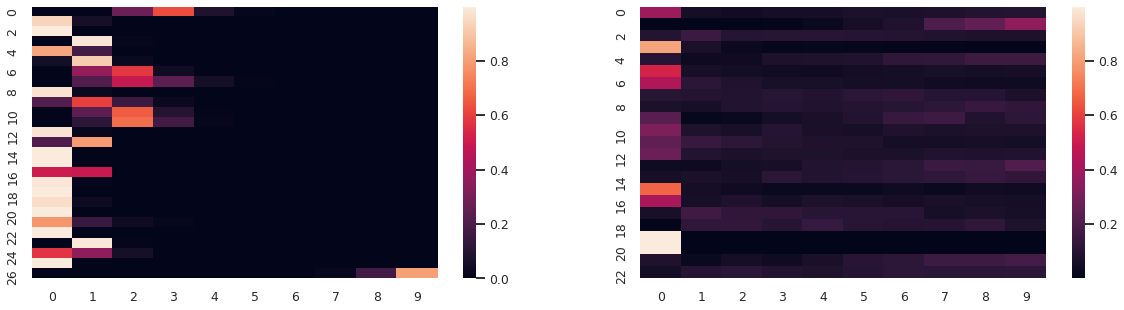

In [52]:
from jax import nn
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(nn.softmax(jnp.stack(res_waic, -1)[:27], -1), ax=axes[0])
sns.heatmap(nn.softmax(jnp.stack(res_waic, -1)[27:], -1), ax=axes[1])

In [23]:
from numpyro.distributions.distribution import Distribution
from numpyro.distributions import constraints
from numpyro.distributions.util import validate_sample

class CategoricalMixture(Distribution):
    arg_constraints = {'logits': constraints.real_vector}
    has_enumerate_support = False
    is_discrete = True

    def __init__(self, logits, weights, mask, validate_args=None):
        if jnp.ndim(logits) < 1:
            raise ValueError("`logits` parameter must be at least one-dimensional.")
        self.logits = logits
        self.weights = weights
        self.mask = mask
        super(CategoricalMixture, self).__init__(batch_shape=jnp.shape(weights)[:-1],
                                                validate_args=validate_args)
    def sample(self, key, sample_shape=()):
        raise NotImplementedError 

    @validate_sample
    def log_prob(self, value):
        mask = jnp.expand_dims(self.mask, -1)
        one_hot_value = jnp.eye(3)[value]
        logits = jnp.sum(jnp.expand_dims(one_hot_value, -1) * self.logits, -2) * mask
        log_z = logsumexp(self.logits, -2) * mask
        log_pmf = logsumexp(jnp.sum(logits - log_z, -3) + jnp.log(self.weights), -1)

        return log_pmf

    @property
    def support(self):
        return constraints.integer_interval(0, jnp.shape(self.logits)[-2] - 1)

In [24]:
def mixture_model(sequences, agents, mask, y=None):
    D = len(sequences)
    T, N = sequences[1]['beliefs'][0].shape[:2]
    
    tau = npyro.sample('tau', dist.HalfCauchy(1.))
    with npyro.plate('N', N):
        weights = npyro.sample('weights', dist.Dirichlet(tau * jnp.ones(D)))
        with npyro.plate('D', D):
            gamma = npyro.sample('gamma', dist.Gamma(20., 2.))
            prob = npyro.sample('prob', dist.Dirichlet(jnp.array([1., 5., 4.])))

        def vec_func(i, nu):
            U = jnp.log(jnp.stack([prob[i, :, 0], prob[i, :, 1], prob[i, :, 2]/2, prob[i, :, 2]/2], -1))
            res = agents[nu].logits(
                    sequences[nu]['beliefs'], 
                    jnp.expand_dims(gamma[i], -1), 
                    1., 
                    jnp.expand_dims(U, -2)
                  )
            return res
        logits = []
        for i, nu in enumerate(sequences):
            logits.append(vec_func(i, nu))

        obs = npyro.sample('obs', CategoricalMixture(logits, weights, mask), obs=y)

# with npyro.handlers.seed(rng_seed=random.PRNGKey(0)):
#     mixture_model(sequences, agents, mask_data, y=responses_data)

In [25]:
nuts_kernel = NUTS(mixture_model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000)

rng_key = random.PRNGKey(234786348)
cutoff = 600
seqs_cut = {}
for nu_max in sequences:
    rng_key, _rng_key = random.split(rng_key)
    seqs_cut[nu_max] = {'beliefs' :(sequences[nu_max]['beliefs'][0][-cutoff:],
                        sequences[nu_max]['beliefs'][1][-cutoff:])}
    
mcmc.run(
    _rng_key, 
    seqs_cut, 
    agents,
    mask_data[-cutoff:],
    y=responses_data[-cutoff:], 
    extra_fields=('potential_energy',)
)

pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(jnp.mean(-pe)))

mcmc.print_summary()
sample = mcmc.get_samples()

Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([[[-0.7033054  -0.47175476 -0.        ]
  [-0.21759875 -0.         -0.05265158]
  [-0.         -0.6987022  -0.65153885]
  ...
  [-1.8429785  -1.487565   -0.        ]
  [-0.03948966 -0.         -0.09108281]
  [-0.3597215  -0.         -0.3772351 ]]

 [[-0.76330316 -0.64973587 -0.        ]
  [-0.1782569  -0.08730344 -0.        ]
  [-0.         -0.2992027  -0.18282089]
  ...
  [-1.8419564  -1.4853681  -0.        ]
  [-0.03961568 -0.         -0.09135436]
  [-0.3605111  -0.         -0.3781346 ]]

 [[-0.731059   -0.5259844  -0.        ]
  [-0.19031341 -0.         -0.01414236]
  [-0.         -0.6161661  -0.52285767]
  ...
  [-1.99934    -1.8792112  -0.        ]
  [-0.02140291 -0.         -0.04218084]
  [-0.12390733 -0.         -0.16076677]]

 ...

 [[-0.7168098  -0.5062812  -0.        ]
  [-0.20128258 -0.         -0.03573397]
  [-0.         -0.65709496 -0.65724784]
  ...
  [-1.6025221  -1.8437862  -0.        ]
  [-0.         -0.02161165 -0.07492917]
  [-0.         -0.2668863  -0.30240908]]

 [[-0.7111022  -0.49571267 -0.        ]
  [-0.20724443 -0.         -0.04456911]
  [-0.         -0.65824246 -0.6587337 ]
  ...
  [-1.506151   -1.7895727  -0.        ]
  [-0.         -0.02653998 -0.08760779]
  [-0.         -0.29659012 -0.33980873]]

 [[-0.76823443 -0.6745244  -0.        ]
  [-0.17305663 -0.09348579 -0.        ]
  [-0.         -0.27002108 -0.19312783]
  ...
  [-1.4817543  -1.7750046  -0.        ]
  [-0.         -0.0278604  -0.09126941]
  [-0.         -0.30286664 -0.34831122]]])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([[[-0.7033054 , -0.47175476, -0.        ],
                              [-0.21759875, -0.        , -0.05265158],
                              [-0.        , -0.6987022 , -0.65153885],
                              ...,
                              [-1.8429785 , -1.487565  , -0.        ],
                              [-0.03948966, -0.        , -0.09108281],
                              [-0.3597215 , -0.        , -0.3772351 ]],
                
                             [[-0.76330316, -0.64973587, -0.        ],
                              [-0.1782569 , -0.08730344, -0.        ],
                              [-0.        , -0.2992027 , -0.18282089],
                              ...,
                              [-1.8419564 , -1.4853681 , -0.        ],
                              [-0.03961568, -0.        , -0.09135436],
                              [-0.3605111 , -0.        , -0.3781346 ]],
                
                             [[-0.731059  , -0.5259844 , -0.        ],
                              [-0.19031341, -0.        , -0.01414236],
                              [-0.        , -0.6161661 , -0.52285767],
                              ...,
                              [-1.99934   , -1.8792112 , -0.        ],
                              [-0.02140291, -0.        , -0.04218084],
                              [-0.12390733, -0.        , -0.16076677]],
                
                             ...,
                
                             [[-0.7168098 , -0.5062812 , -0.        ],
                              [-0.20128258, -0.        , -0.03573397],
                              [-0.        , -0.65709496, -0.65724784],
                              ...,
                              [-1.6025221 , -1.8437862 , -0.        ],
                              [-0.        , -0.02161165, -0.07492917],
                              [-0.        , -0.2668863 , -0.30240908]],
                
                             [[-0.7111022 , -0.49571267, -0.        ],
                              [-0.20724443, -0.        , -0.04456911],
                              [-0.        , -0.65824246, -0.6587337 ],
                              ...,
                              [-1.506151  , -1.7895727 , -0.        ],
                              [-0.        , -0.02653998, -0.08760779],
                              [-0.        , -0.29659012, -0.33980873]],
                
                             [[-0.76823443, -0.6745244 , -0.        ],
                              [-0.17305663, -0.09348579, -0.        ],
                              [-0.        , -0.27002108, -0.19312783],
                              ...,
                              [-1.4817543 , -1.7750046 , -0.        ],
                              [-0.        , -0.0278604 , -0.09126941],
                              [-0.        , -0.30286664, -0.34831122]]], dtype=float32)
       tangent = Traced<ShapedArray(float32[600,50,3]):JaxprTrace(level=1/0)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.

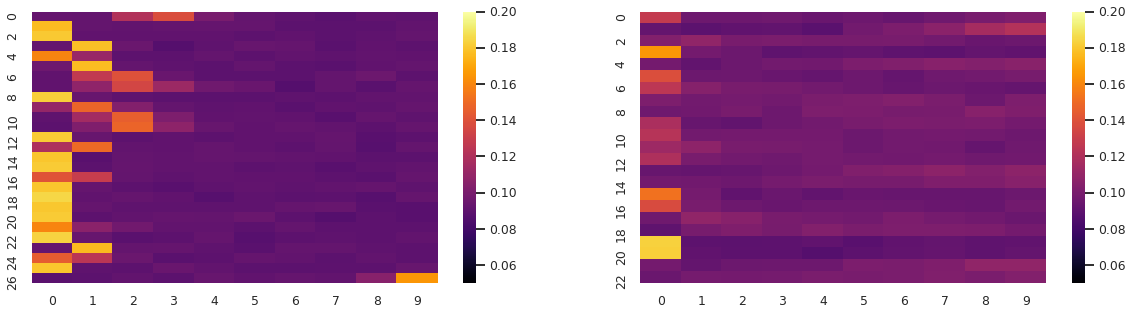

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.heatmap(sample['weights'].mean(0)[:27], ax=axes[0], cmap='inferno', vmin=.05, vmax=.2);
sns.heatmap(sample['weights'].mean(0)[27:], ax=axes[1], cmap='inferno', vmin=.05, vmax=.2);